In [1]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Grid radars based on date and time of interest

In [2]:
filename = "C:/Users/omitu/Desktop/KHGX/KHGX20220810_220039_V06"
radar = pyart.io.read(filename)
radar.fields.keys()

#Set weighting function
weight_func='Barnes' #nearest, Cressman

#Create a gatefilter
gfilter = pyart.filters.GateFilter(radar)
gfilter.exclude_below('cross_correlation_ratio',0.8)
gfilter.exclude_below('reflectivity',-10)


In [3]:
radar.fields.keys()

dict_keys(['cross_correlation_ratio', 'differential_reflectivity', 'differential_phase', 'velocity', 'reflectivity', 'clutter_filter_power_removed', 'spectrum_width'])

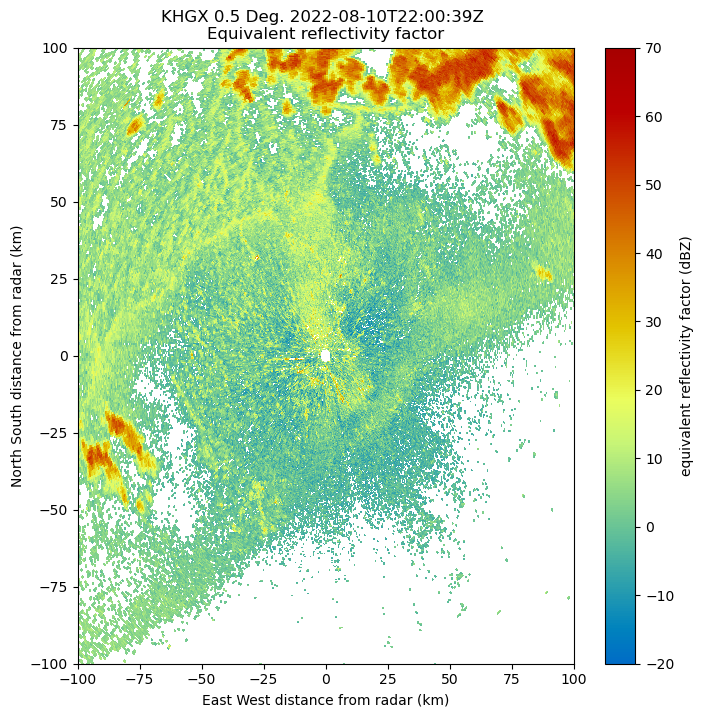

In [4]:
fig = plt.figure(figsize=(8,8))
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity',sweep=0,vmin=-20,vmax=70)
display.set_limits(xlim=(-100,100),ylim=(-100,100))
#plt.savefig('Raw_Z.png')

In [5]:
#KDP calc
kdp_calc = True

#Calculate KDP if desired
if(kdp_calc):
    kdp_vulpiani = pyart.retrieve.kdp_vulpiani(radar, gatefilter=None, band='S', windsize=10, n_iter=10, interp=False,parallel=True)
    radar.add_field('kdp', kdp_vulpiani[0])

In [6]:
#Create a grid based on our radar object (z,y,x)
#Grid shape is number of points in each dimension
#Grid limits are the dimension limits in meters

grid = pyart.map.grid_from_radars(
    radar,
    grid_shape=(41, 401, 401),
    gridding_algo = 'map_gates_to_grid',
    weighting_function = weight_func,
    gatefilters = gfilter,
    grid_limits=(
        (
            0.0,
            20000,
        ),
        (-100000.0, 100000.0),
        (-100000, 100000.0),
    ),
)

In [7]:
radar_grid = grid.to_xarray()

# Filter convective cells based on date and time of interest

In [8]:
tracked_cells = xr.open_dataset('C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/stats/trackstats_20220801.0000_20220831.2359.nc')
tracked_cells

<xarray.Dataset>
Dimensions:                  (tracks: 11705, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 11701 11702 11703 11704
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 ...
    base_time                (tracks, times) datetime64[ns] ...
    meanlat                  (tracks, times) float32 ...
    meanlon                  (tracks, times) float32 ...
    area                     (tracks, times) float32 ...
    cloudnumber              (tracks, times) float64 ...
    ...                       ...
    start_split_tracknumber  (tracks) float64 ...
    start_split_timeindex    (tracks) float64 ...
    start_split_cloudnumber  (tracks) float64 ...
    end_merge_tracknumber    (tracks) float64 ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [9]:
# Define your time range
start_time = np.datetime64('2022-08-10T22:00:39')
end_time = np.datetime64('2022-08-10T22:00:59')

# Create a mask where base_time is within the specified range
time_mask = (tracked_cells.start_basetime >= start_time) & (tracked_cells.start_basetime <= end_time)

# Apply this mask across the 'tracks' dimension
filtered_ds = tracked_cells.where(time_mask, drop=True)
filtered_ds

<xarray.Dataset>
Dimensions:                  (tracks: 7, times: 100)
Coordinates:
  * tracks                   (tracks) int64 2796 2797 2798 2799 2800 2801 2802
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) float64 1.0 1.0 7.0 4.0 2.0 2.0 6.0
    base_time                (tracks, times) datetime64[ns] 2022-08-10T22:00:...
    meanlat                  (tracks, times) float32 30.19 nan nan ... nan nan
    meanlon                  (tracks, times) float32 -94.03 nan nan ... nan nan
    area                     (tracks, times) float32 52.0 nan nan ... nan nan
    cloudnumber              (tracks, times) float64 12.0 nan nan ... nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 2.747e+03 2.791e+03 ... nan nan
    start_split_timeindex    (tracks) float64 19.0 1.0 nan nan nan nan nan
    start_split_cloudnumber  (tracks) float64 2.0 6.0 nan nan nan nan nan
    end_merge_tracknumber    (tracks) float64 2.747e+03 nan ... nan 2.804e+03
    end_merge_timeindex      (tracks) float64 21.0 nan nan nan nan nan 5.0
    end_merge_cloudnumber    (tracks) float64 1.0 nan nan nan nan nan 1.0
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [10]:
# Calculate cell area

filtered_ds.cell_area.std()

<xarray.DataArray 'cell_area' ()>
array(20.97511864)

# Filter gridded radars based on convective cells

In [11]:
radar_grid

<xarray.Dataset>
Dimensions:                       (time: 1, z: 41, y: 401, x: 401)
Coordinates:
  * time                          (time) object 2022-08-10 22:00:39.675000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                           (y, x) float64 28.57 28.57 ... 30.37 30.37
    lon                           (y, x) float64 -96.1 -96.1 ... -94.04 -94.04
  * y                             (y) float64 -1e+05 -9.95e+04 ... 1e+05
  * x                             (x) float64 -1e+05 -9.95e+04 ... 1e+05
Data variables:
    cross_correlation_ratio       (time, z, y, x) float32 1.022 1.018 ... nan
    spectrum_width                (time, z, y, x) float32 nan nan ... nan nan
    differential_reflectivity     (time, z, y, x) float32 9.527 9.549 ... nan
    velocity                      (time, z, y, x) float32 nan nan ... nan nan
    kdp                           (time, z, y, x) float64 0.07817 0.1075 ... nan
    clutter_filter_power_removed  (time, z, y, x) float32 -6.0 -6.0 ... nan nan
    differential_phase            (time, z, y, x) float32 104.6 94.72 ... nan
    reflectivity                  (time, z, y, x) float32 6.01 6.053 ... nan nan
    ROI                           (time, z, y, x) float32 3.703e+03 ... 4.703...

In [12]:
filtered_ds.isel(tracks=1)

<xarray.Dataset>
Dimensions:                  (times: 100)
Coordinates:
    tracks                   int64 2797
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           float64 1.0
    base_time                (times) datetime64[ns] 2022-08-10T22:00:39.67500...
    meanlat                  (times) float32 30.45 nan nan nan ... nan nan nan
    meanlon                  (times) float32 -95.34 nan nan nan ... nan nan nan
    area                     (times) float32 21.0 nan nan nan ... nan nan nan
    cloudnumber              (times) float64 18.0 nan nan nan ... nan nan nan
    ...                       ...
    start_split_tracknumber  float64 2.791e+03
    start_split_timeindex    float64 1.0
    start_split_cloudnumber  float64 6.0
    end_merge_tracknumber    float64 nan
    end_merge_timeindex      float64 nan
    end_merge_cloudnumber    float64 nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [13]:
# Extract the coordinates from the convective cell data
latitudes = filtered_ds.cell_meanlat.values[~np.isnan(filtered_ds.cell_meanlat.values)]
longitudes = filtered_ds.cell_meanlon.values[~np.isnan(filtered_ds.cell_meanlon.values)]

In [14]:
# Buffer size (example: 0.01 degrees)
lat_buffer = 0.01
lon_buffer = 0.01

# Function to add buffers around points to reach a target number of points
def add_buffers(arr, buffer_size, target_length):
    # Calculate how many buffers to add around each point to approximate the target length
    num_buffers_per_point = (target_length - len(arr)) // (2 * len(arr))  # 2 buffers per original point (add and subtract)
    additional_points_needed = target_length - len(arr) - (2 * num_buffers_per_point * len(arr))
    
    new_points = []
    for point in arr:
        new_points.append(point)  # Add the original point
        # Generate buffers around each point
        for i in range(1, num_buffers_per_point + 1):
            new_points.append(point + i * buffer_size)
            new_points.append(point - i * buffer_size)
    
    # If additional points are needed, add them around the first point
    for i in range(1, additional_points_needed // 2 + 1):
        new_points.append(arr[0] + (num_buffers_per_point + i) * buffer_size)
        new_points.append(arr[0] - (num_buffers_per_point + i) * buffer_size)
    
    # Ensure the length matches the target length, trim if necessary
    return np.array(new_points[:target_length])

# Add buffers and generate new latitudes and longitudes
new_latitudes = add_buffers(latitudes, lat_buffer, 45)
new_longitudes = add_buffers(longitudes, lon_buffer, 45)

print("New Latitudes:", new_latitudes)
print("New Longitudes:", new_longitudes)


New Latitudes: [30.18854523 30.44976997 30.44893837 30.44411278 30.43258858 30.40500259
 30.37766075 30.3520546  30.33218193 29.52687836 29.52330208 29.5278244
 29.52274513 29.19407845 29.19107437 30.10186195 30.09606934 30.10127831
 30.0976429  30.0972538  30.09543419 30.09381676 30.09386444 30.19854523
 30.17854523 30.20854523 30.16854523 30.21854523 30.15854523 30.22854523
 30.14854523 30.23854523 30.13854523 30.24854523 30.12854523 30.25854523
 30.11854523 30.26854523 30.10854523 30.27854523 30.09854523 30.28854523
 30.08854523 30.29854523 30.07854523]
New Longitudes: [-94.03308868 -95.33698273 -94.14598846 -94.15588379 -94.16265869
 -94.17027283 -94.16288757 -94.15492249 -94.16264343 -95.95276642
 -95.95381927 -95.95680237 -95.9631958  -95.85506439 -95.85853577
 -94.88589478 -94.87671661 -95.21350098 -95.21211243 -95.20464325
 -95.19779968 -95.19059753 -95.18378448 -94.02308868 -94.04308868
 -94.01308868 -94.05308868 -94.00308868 -94.06308868 -93.99308868
 -94.07308868 -93.9830886

In [15]:
import numpy as np
import xarray as xr

# Example latitudes and longitudes of interest
latitudes = new_latitudes
longitudes = new_longitudes

# Assuming radar_grid is your dataset and it has 2D lat and lon coordinates
lat_grid = radar_grid['lat'].values  # 2D array of latitudes
lon_grid = radar_grid['lon'].values  # 2D array of longitudes

selected_data = []

for point_lat, point_lon in zip(latitudes, longitudes):
    # Calculate squared distance to avoid unnecessary sqrt computation for comparison
    distance_squared = (lat_grid - point_lat)**2 + (lon_grid - point_lon)**2
    
    # Find the index of the minimum distance
    min_dist_idx = np.unravel_index(np.argmin(distance_squared), distance_squared.shape)
    
    # Corrected indexing using the 'y' and 'x' dimensions
    nearest_point_data = radar_grid.isel(y=min_dist_idx[0], x=min_dist_idx[1])
    selected_data.append(nearest_point_data)


# selected_data now contains the data points closest to your specified latitudes and longitudes
final_data = xr.concat(selected_data, dim='y', data_vars='all')
final_data_2 = xr.concat(selected_data, dim='x', data_vars='all')
merged_data = final_data.combine_first(final_data_2)

In [16]:
merged_data = merged_data.transpose("z", "y", "x", "time")   # Rearrange dimensions

In [17]:
merged_data

<xarray.Dataset>
Dimensions:                       (y: 45, time: 1, z: 41, x: 45)
Coordinates:
  * time                          (time) object 2022-08-10 22:00:39.675000
  * z                             (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
  * y                             (y) float64 8e+04 1e+05 ... 9.25e+04 6.8e+04
  * x                             (x) float64 1e+05 -2.5e+04 ... 1e+05 9e+04
Data variables:
    cross_correlation_ratio       (z, y, x, time) float32 0.9871 0.9871 ... nan
    spectrum_width                (z, y, x, time) float32 nan nan ... nan nan
    differential_reflectivity     (z, y, x, time) float32 1.213 1.213 ... nan
    velocity                      (z, y, x, time) float32 nan nan ... nan nan
    kdp                           (z, y, x, time) float64 0.7459 0.7459 ... nan
    clutter_filter_power_removed  (z, y, x, time) float32 nan -6.0 ... nan nan
    differential_phase            (z, y, x, time) float32 94.04 94.04 ... nan
    reflectivity                  (z, y, x, time) float32 47.21 47.21 ... nan
    ROI                           (z, y, x, time) float32 3.353e+03 ... 3.954...

# COntinue with CFAD

In [18]:
#CFAD settings
zlims=[-20, 65]
zdrlims=[-1, 3]
rholims=[0.9, 1.02]
kdplims=[-1,3]
#lims = [-50000,0,-75000,30000]
lims=[-100000,-50000,-50000,50000]
#lims = [-50000,50000,-50000,50000]
ymax=10
norm_opt = 2 #1) Normalize at each height only, 2) Normalize across all heights

#CFAD increment
dz = 5
dzdr = 0.5
drho = 0.0025
dkdp = 0.1

In [19]:
# Function to apply masking and squeezing
def process_variable(data_array):
    # Extract the numpy array from the DataArray
    np_array = data_array.values
    
    # Define the mask condition
    mask_condition = np.isnan(np_array)
    
    # Apply the mask to create a masked array
    masked_array_np = np.ma.masked_where(mask_condition, np_array)
    
    # Squeeze the masked array to remove the singleton dimension
    squeezed_masked_array = np.squeeze(masked_array_np)
    
    # Return the processed masked array
    return squeezed_masked_array

In [20]:
differential_reflectivity = merged_data['differential_reflectivity']
masked_differential_reflectivity = process_variable(differential_reflectivity)

kdp = merged_data['kdp']
masked_kdp = process_variable(kdp)

cross_correlation_ratio = merged_data['cross_correlation_ratio']
masked_cross_correlation_ratio = process_variable(cross_correlation_ratio)

reflectivity = merged_data['reflectivity']
masked_reflectivity = process_variable(reflectivity)

In [21]:
[X, Y] = np.meshgrid(merged_data.x, merged_data.y)

In [22]:
def cfad_calc(data,bins,lims,norm_opt=1):
    #lims is a 4-element list or tuple (xmin, xmax, ymin, ymax). 
    #lims = 0: Use whole domain
    #bins: array of bin edge locations
    #norm_opt: 1) Normalize at each level only, 2) Normalize by max count
    
    #Initialize histogram
    hist2d = np.zeros((np.size(bins)-1,data.shape[0]))
    
    #Check if the user wants a limited domain
    limit_domain = np.size(lims) > 1
    
    if(limit_domain):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        
    #loop over all heights
    for lev in range(data.shape[0]):
        if(limit_domain):
            data_hist = np.ma.compressed(data[lev,a])
        else:
            data_hist = np.ma.compressed(data[lev,:])
        
        #Calculate histogram
        histogram, bin_edges = np.histogram(np.ravel(data_hist), bins)
        
        #Normalize histogram
        if(norm_opt == 1):
            if(np.sum(histogram) > 0):
                hist2d[:,lev] = histogram/np.sum(histogram)
        elif(norm_opt == 2):
            hist2d[:,lev] = histogram
        
    if(norm_opt == 2):
        #Normalize by maximum count across all heights
        hist2d /= np.max(hist2d)
                
    bin_ctrs = (bins[:-1]+bins[1:])/2
    
    return hist2d,bin_ctrs
    
def vert_stats(data,lims):
    if(np.size(lims) > 1):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        data_mean = np.ma.median(data[:,a],axis=1)
    else:
        data_mean = np.ma.mean(np.ma.mean(data,axis=2),axis=1)
        
    return data_mean
    
dzgrid = grid.z["data"][2]-grid.z["data"][1]
#CFAD X
data =  masked_reflectivity
binsZ = np.arange(zlims[0], zlims[1], dz)

[hist_Z, Zctr] = cfad_calc(data,binsZ,lims,norm_opt)
#hist_Z /= dz
meanZ = vert_stats(data,lims)

#CFAD ZDR
data = masked_differential_reflectivity
binsZDR = np.arange(zdrlims[0], zdrlims[1], dzdr)
[hist_ZDR, ZDRctr] = cfad_calc(data,binsZDR,lims,norm_opt)
#hist_ZDR /= (dzdr*10)
meanZDR = vert_stats(data,lims)

#CFAD rhohv
data = masked_cross_correlation_ratio
binsrho = np.arange(rholims[0], rholims[1], drho)
[hist_rho, rhoctr] = cfad_calc(data,binsrho,lims,norm_opt)
#hist_rho /= (drho*10000)
meanrho = vert_stats(data,lims)

#CFAD KDP
if(kdp_calc):
    data = masked_kdp
    binskdp = np.arange(kdplims[0], kdplims[1], dkdp)
    [hist_kdp,kdpctr] = cfad_calc(data,binskdp,lims,norm_opt)
    #hist_kdp /= (dkdp*100)
    meankdp = vert_stats(data,lims)

In [23]:
def cfad_calc(data,bins,lims,norm_opt=1):
    #lims is a 4-element list or tuple (xmin, xmax, ymin, ymax). 
    #lims = 0: Use whole domain
    #bins: array of bin edge locations
    #norm_opt: 1) Normalize at each level only, 2) Normalize by max count
    
    #Initialize histogram
    hist2d = np.zeros((np.size(bins)-1,data.shape[0]))
    
    #Check if the user wants a limited domain
    limit_domain = np.size(lims) > 1
    
    if(limit_domain):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        
    #loop over all heights
    for lev in range(data.shape[0]):
        if(limit_domain):
            data_hist = np.ma.compressed(data[lev,a,b])
        else:
            data_hist = np.ma.compressed(data[lev,:,:])
        
        #Calculate histogram
        histogram, bin_edges = np.histogram(np.ravel(data_hist), bins)
        
        #Normalize histogram
        if(norm_opt == 1):
            if(np.sum(histogram) > 0):
                hist2d[:,lev] = histogram/np.sum(histogram)
        elif(norm_opt == 2):
            hist2d[:,lev] = histogram
        
    if(norm_opt == 2):
        #Normalize by maximum count across all heights
        hist2d /= np.max(hist2d)
                
    bin_ctrs = (bins[:-1]+bins[1:])/2
    
    return hist2d,bin_ctrs
    
def vert_stats(data,lims):
    if(np.size(lims) > 1):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        data_mean = np.ma.median(data[:,a,b],axis=1)
    else:
        data_mean = np.ma.mean(np.ma.mean(data,axis=2),axis=1)
        
    return data_mean
    
dzgrid = grid.z["data"][2]-grid.z["data"][1]
#CFAD X
data =  masked_reflectivity
binsZ = np.arange(zlims[0], zlims[1], dz)

[hist_Z, Zctr] = cfad_calc(data,binsZ,lims,norm_opt)
#hist_Z /= dz
meanZ = vert_stats(data,lims)

#CFAD ZDR
data = masked_differential_reflectivity
binsZDR = np.arange(zdrlims[0], zdrlims[1], dzdr)
[hist_ZDR, ZDRctr] = cfad_calc(data,binsZDR,lims,norm_opt)
#hist_ZDR /= (dzdr*10)
meanZDR = vert_stats(data,lims)

#CFAD rhohv
data = masked_cross_correlation_ratio
binsrho = np.arange(rholims[0], rholims[1], drho)
[hist_rho, rhoctr] = cfad_calc(data,binsrho,lims,norm_opt)
#hist_rho /= (drho*10000)
meanrho = vert_stats(data,lims)

#CFAD KDP
if(kdp_calc):
    data = masked_kdp
    binskdp = np.arange(kdplims[0], kdplims[1], dkdp)
    [hist_kdp,kdpctr] = cfad_calc(data,binskdp,lims,norm_opt)
    #hist_kdp /= (dkdp*100)
    meankdp = vert_stats(data,lims)

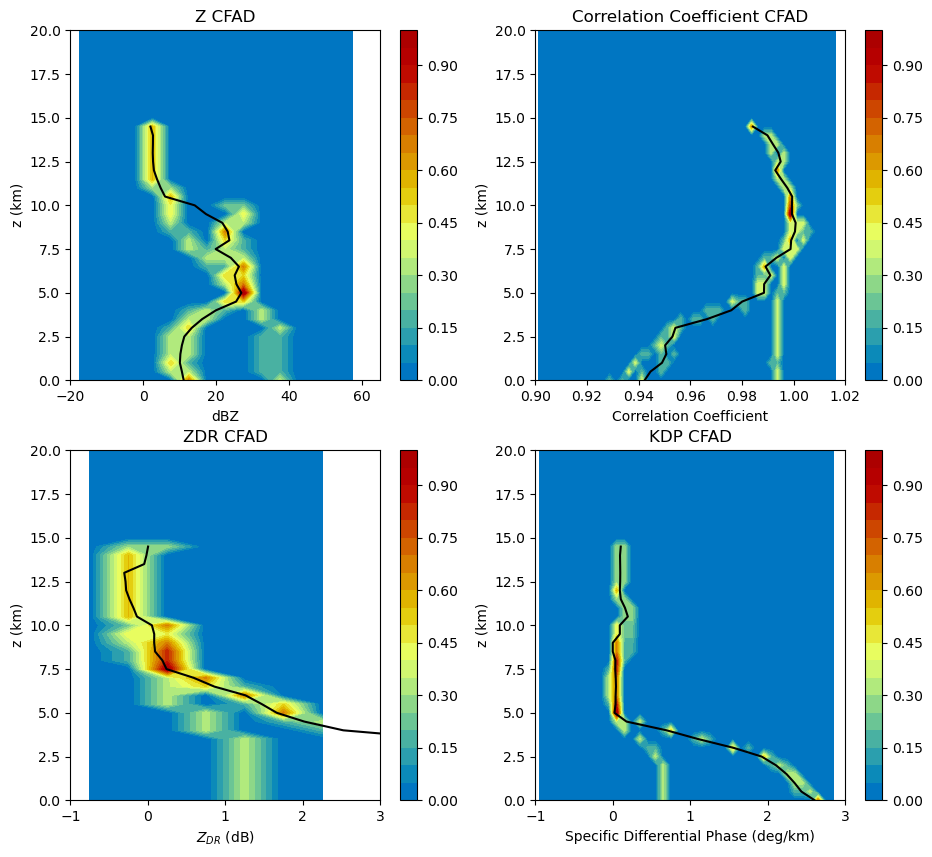

In [24]:
#Plotting levels for contours
ymax=20
fig,ax = plt.subplots(2,2,figsize=(11,10))
[z,b]=np.meshgrid(grid.z["data"],Zctr)
pcm=ax[0,0].contourf(b,z/1000,hist_Z,levels=20,cmap='pyart_HomeyerRainbow')
ax[0,0].plot(meanZ,grid.z["data"]/1000,'-k')
#ax[0,0].contour(b,z/1000,hist_Z,levels=np.arange(0.05,1,0.05),colors='k')
ax[0,0].set_xlabel('dBZ')
ax[0,0].set_ylabel('z (km)')
ax[0,0].set_title('Z CFAD')
#ax[0,0].set_title('Z CFAD (% of Data per dBZ per km)')
ax[0,0].set_xlim(zlims)
ax[0,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,0])

[z,b]=np.meshgrid(grid.z["data"],ZDRctr)
pcm=ax[1,0].contourf(b,z/1000,hist_ZDR,levels=20,cmap='pyart_HomeyerRainbow')
#ax[1,0].contour(b,z/1000,hist_ZDR,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[1,0].plot(meanZDR,grid.z["data"]/1000,'-k')
ax[1,0].set_xlabel('$Z_{DR}$ (dB)')
ax[1,0].set_ylabel('z (km)')
#ax[1,0].set_title('ZDR CFAD (% of Data per 0.1 dB per km)')
ax[1,0].set_title('ZDR CFAD')
ax[1,0].set_xlim(zdrlims)
ax[1,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[1,0])

[z,b]=np.meshgrid(grid.z["data"],rhoctr)
pcm=ax[0,1].contourf(b,z/1000,hist_rho,levels=20,cmap='pyart_HomeyerRainbow')
#ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[0,1].plot(meanrho,grid.z["data"]/1000,'-k')
ax[0,1].set_xlabel('Correlation Coefficient')
ax[0,1].set_ylabel('z (km)')
#ax[0,1].set_title('Correlation Coefficient CFAD (% of Data per 0.001 CC per km)')
ax[0,1].set_title('Correlation Coefficient CFAD')
ax[0,1].set_xlim(rholims)
ax[0,1].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,1])

if(kdp_calc):
    [z,b]=np.meshgrid(grid.z["data"],kdpctr)
    pcm=ax[1,1].contourf(b,z/1000,hist_kdp,levels=20,cmap='pyart_HomeyerRainbow')
    #ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
    ax[1,1].plot(meankdp,grid.z["data"]/1000,'-k')
    ax[1,1].set_xlabel('Specific Differential Phase (deg/km)')
    #ax[1,1].set_title('KDP CFAD (% of Data per 0.01 deg/km per km)')
    ax[1,1].set_title('KDP CFAD')
    ax[1,1].set_ylabel('z (km)')
    ax[1,1].set_ylim(0,ymax)
    ax[1,1].set_xlim(kdplims)
    fig.colorbar(pcm, ax=ax[1,1])

fig.savefig('CFAD_norm_1.png')



# Characterize the near-storm environment

In [ ]:
# Here, we would be using the data based on the period of the storm, i.e. August 10, 22:00 UTC to August 11, 04:00 UTC

In [45]:
# Define your time range
start_time = np.datetime64('2022-08-10T22:00:00')
end_time = np.datetime64('2022-08-11T04:00:59')

# Create a mask where base_time is within the specified range
time_mask = (tracked_cells.start_basetime >= start_time) & (tracked_cells.start_basetime <= end_time)

# Apply this mask across the 'tracks' dimension
filtered_ds = tracked_cells.where(time_mask, drop=True)
filtered_ds

<xarray.Dataset>
Dimensions:                  (tracks: 210, times: 100)
Coordinates:
  * tracks                   (tracks) int64 2796 2797 2798 ... 3003 3004 3005
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) float64 1.0 1.0 7.0 4.0 ... 2.0 2.0 2.0
    base_time                (tracks, times) datetime64[ns] 2022-08-10T22:00:...
    meanlat                  (tracks, times) float32 30.19 nan nan ... nan nan
    meanlon                  (tracks, times) float32 -94.03 nan nan ... nan nan
    area                     (tracks, times) float32 52.0 nan nan ... nan nan
    cloudnumber              (tracks, times) float64 12.0 nan nan ... nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 2.747e+03 2.791e+03 ... nan
    start_split_timeindex    (tracks) float64 19.0 1.0 nan nan ... 11.0 7.0 nan
    start_split_cloudnumber  (tracks) float64 2.0 6.0 nan nan ... 1.0 2.0 nan
    end_merge_tracknumber    (tracks) float64 2.747e+03 nan nan ... nan nan
    end_merge_timeindex      (tracks) float64 21.0 nan nan nan ... 14.0 nan nan
    end_merge_cloudnumber    (tracks) float64 1.0 nan nan nan ... 2.0 nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Tue Aug  1 20:43:12 2023
    startdate:             20220801.0000
    enddate:               20220831.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [40]:
# Convection initiation classification based on Marquis et al., 2022

# Long-lived vs sgort-lived cells: Total duration >= 3 or less than 3 consecutive radar volumes, respectively
# Deep or shallow cells: 20-dBZ echo-top height (ETH) >= 66% or < 66% of the MU EL height, respectively
# Wide or narrow cells: cell area >= 50 km2 or < 50 km2, respectively.

In [52]:
# Analyze each track using list comprehensions
tracks_with_3_or_more_consecutive = [i for i, track in enumerate(data['cell_area'].values) if not np.isnan(track[:3]).any()]
tracks_with_less_than_3_consecutive = [i for i, track in enumerate(data['cell_area'].values) if np.isnan(track[:3]).any()]

# Translate indices back to track IDs
long_lived_tracks = data.tracks.values[tracks_with_3_or_more_consecutive]
short_lived_tracks = data.tracks.values[tracks_with_less_than_3_consecutive]


# Print results
print(f"Number of long-lived tracks: {len(long_lived_tracks)}")
print(f"Number of short_lived tracks: {len(short_lived_tracks)}")
# print(f"\nTracks with less than 3 consecutive non-NaN volumes from the start: {len(short_lived_tracks)}")
# print("Track IDs:", short_lived_tracks)


Number of long-lived tracks: 113
Number of short_lived tracks: 97


In [50]:
# 
tracks_with_area_50_or_more = [i for i, track in enumerate(data['area'].values) 
                               if not np.isnan(track[:3]).any() and all(area >= 50 for area in track[:3])]
tracks_with_area_less_than_50 = [i for i, track in enumerate(data['area'].values) 
                                 if not np.isnan(track[:3]).any() and any(area < 50 for area in track[:3])]

# Translate indices to track IDs
wide_cells = data.tracks.values[tracks_with_area_50_or_more]
narrow_cells = data.tracks.values[tracks_with_area_less_than_50]

# Output results
print(f"Number of wide tracks: {len(wide_cells)}")
print(f"Number of narrow tracks: {len(narrow_cells)}")


Number of wide tracks: 38
Number of narrow tracks: 75


In [49]:
import xarray as xr

# Load the convective cell data
conv_cells_data = filtered_ds

# Determine deep (ETH >= 10 km) and shallow (ETH < 10 km) cells from maxETH_20dbz in the first three time points
deep_threshold_km = 10
max_eth_first_3 = conv_cells_data['maxETH_20dbz'].isel(times=slice(0, 3)).max(dim='times')
deep_cells = max_eth_first_3.where(max_eth_first_3 >= deep_threshold_km, drop=True).tracks.values
shallow_cells = max_eth_first_3.where(max_eth_first_3 < deep_threshold_km, drop=True).tracks.values

# Print counts and example track IDs
print(f"Number of deep cells: {len(deep_cells)}")
print(f"Number of shallow cells: {len(shallow_cells)}")


Number of deep cells: 99
Number of shallow cells: 111


In [56]:
# Define the threshold for classifying intense cells
intense_threshold_dbz = 50

# Classify cells as intense or weak based on max_dbz within the first three volumes
intense_cells = conv_cells_data['max_dbz'].isel(times=slice(0, 3)).max(dim='times').where(lambda x: x >= intense_threshold_dbz, drop=True).tracks.values
weak_cells = conv_cells_data['max_dbz'].isel(times=slice(0, 3)).max(dim='times').where(lambda x: x < intense_threshold_dbz, drop=True).tracks.values

# Output counts and example track IDs
print(f"Intense cells: {len(intense_cells)}")
print(f"Weak cells: {len(weak_cells)}")


Intense cells: 56
Weak cells: 154
